# Предсказание CTR 2018

https://www.kaggle.com/c/babushka-ctr-2018

Описание файлов

Вам представлены данные поисковых запросов, по которым была показана контекстная реклама одного рекламодателя.

    train.csv - the training set
    test.csv - the test set.

Поля данных

    RowId - идшник для сабмишена
    AveragePosition - средняя позиция объявления на странице выдачи
    CampaignId - рекламная кампания, обычно содежит объявления одной тематики
    AdGroupId  - содержит группу объявлений, которые показываются при совпадении запроса пользователя (Query) с ключевым словом рекламодателя (описывается KeywordId, сами ключевые слова не включены в датасет)


In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler

In [128]:
import pandas as pd
train = pd.read_csv("train.csv")
test = pd.read_csv("test_upd.csv")

Переделаем дату в datetime на всякий случай и посчитаем, сколько было сделано и не сделано кликов

In [129]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
train['NotClicks'] = train['Impressions'] - train['Clicks']
train.drop(['Impressions'], axis=1, inplace=True)

Посмотрим на данные

In [130]:
train.head()

,CampaignId,AdGroupId,KeywordId,Query,QueryMatchTypeWithVariant,Device,Date,AveragePosition,Clicks,NotClicks
0,150950690,7953835370,116881275,may loan,NEAR_EXACT,HIGH_END_MOBILE,2016-08-26,1.0,1,0
1,150950690,7953835370,116881275,my lloan,NEAR_EXACT,DESKTOP,2016-09-16,1.0,1,0
2,150950690,7953835370,116881275,my loan,EXACT,DESKTOP,2016-04-05,2.0,1,0
3,150950690,7953835370,116881275,my loan,EXACT,DESKTOP,2016-04-12,2.0,1,0
4,150950690,7953835370,116881275,my loan,EXACT,DESKTOP,2016-04-18,1.0,0,1


Перейдем к бинарной классификации. Для этого размножим строки в количестве равном Clicks и NotClicks с соответствующим классом 0 или 1

In [131]:
def reproduce_rows(df):        
    for i, *row, clicks, not_clicks in df.itertuples():
        while clicks > 0:
            yield row + [1]
            clicks -= 1
        while not_clicks > 0:
            yield row + [0]
            not_clicks -= 1
            
columns = list(train.columns.values)   
columns.remove('NotClicks')
train = pd.DataFrame([*reproduce_rows(train)], columns=columns)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569532 entries, 0 to 569531
Data columns (total 9 columns):
CampaignId                   569532 non-null int64
AdGroupId                    569532 non-null int64
KeywordId                    569532 non-null int64
Query                        569532 non-null object
QueryMatchTypeWithVariant    569532 non-null object
Device                       569532 non-null object
Date                         569532 non-null datetime64[ns]
AveragePosition              569532 non-null float64
Clicks                       569532 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 39.1+ MB


Посмотрим на соотношение этих кликов

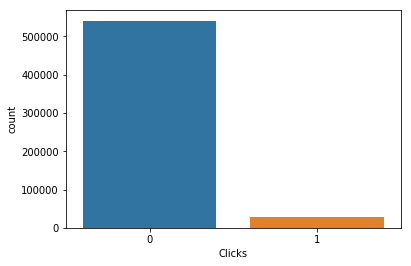

In [132]:
sns.countplot(x="Clicks", data=train)

Посмотрим на данные по кампаниям

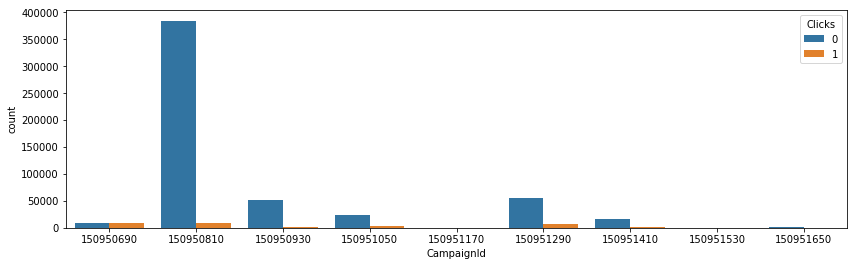

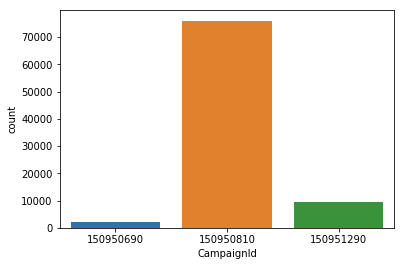

In [133]:
plt.figure(figsize=(14,4))
sns.countplot(x="CampaignId", data=train, hue=train['Clicks'])
plt.show()
sns.countplot(x="CampaignId", data=test)
plt.show()

In [134]:
pd.crosstab(train.CampaignId, train.Clicks, normalize='index')

Clicks,0,1
CampaignId,,
150950690,0.490736,0.509264
150950810,0.979082,0.020918
150950930,0.984000,0.016000
150951050,0.895692,0.104308
150951170,0.732955,0.267045
150951290,0.887885,0.112115
150951410,0.954277,0.045723
150951530,0.936605,0.063395
150951650,0.813084,0.186916


Можно заметить, что в трейновой выборке 9 кампаний, в тестовой 3, причем эти три являются подмножеством кампаний из трейновой. Придется выпилить все кампании не из теста. Кроме того, по рекламам кампании 150950690 наблюдается явная аномалия: количество кликов даже немного больше чем количество "некликов". Посмотрим, по каким запросам она показывается

In [135]:
train = train.loc[train['CampaignId'].isin([150950690, 150950810, 150951290])]
interest_campaign = train.loc[train['CampaignId'] == 150950690]
interest_campaign['Query'].value_counts()[:10]

myloan             11564
my loan             2210
mylan               1401
my loan sverige      265
myloan se            231
mylån                203
www myloan se        159
my lån               132
myloan omdöme        131
mylone               113
Name: Query, dtype: int64

Люди ищут какой-то MyLoan, видимо какие-то кредиты ¯\_(ツ)_/¯

Вообще судя по данным, столбец Query кодируется ключом из столбца KeywordId и точностью его написания QueryMatchTypeWithVariant, так что его можно скипнуть. Взглянем как раз на QueryMatchTypeWithVariant

Clicks,0,1
QueryMatchTypeWithVariant,,
EXACT,0.962038,0.037962
EXPANDED,0.877733,0.122267
NEAR_EXACT,0.814298,0.185702
NEAR_PHRASE,0.734168,0.265832
PHRASE,0.885723,0.114277


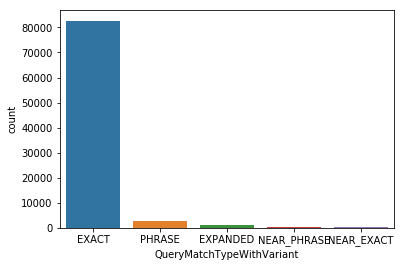

In [136]:
sns.countplot(x="QueryMatchTypeWithVariant", data=test)
pd.crosstab(train.QueryMatchTypeWithVariant, train.Clicks, normalize='index')

Здесь никаких аномалий - по точному вводу кликают чаще и показывается она чаще, по приблизительной фразе кликают реже. Реже всего кликают по Expanded, посмотрим, что это у нас такое

In [137]:
train.loc[train['QueryMatchTypeWithVariant'] == 'EXPANDED']

,CampaignId,AdGroupId,KeywordId,Query,QueryMatchTypeWithVariant,Device,Date,AveragePosition,Clicks
12496,150950690,7953835370,44520786825,how much housing loan i can get for my salary,EXPANDED,DESKTOP,2016-09-05,1.0,1
12501,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-19,1.0,1
12502,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,1
12503,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,0
12504,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,0
12505,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,0
12513,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-01-08,1.0,1
12514,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-02-03,1.0,0
12515,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-04-21,1.0,1
12516,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-04-22,1.0,1


Судя по всему, это запросы, подходящие под тематику рекламы.

Посмотрим на девайсы

Clicks,0,1
Device,,
DESKTOP,0.940015,0.059985
HIGH_END_MOBILE,0.960679,0.039321
TABLET,0.936681,0.063319


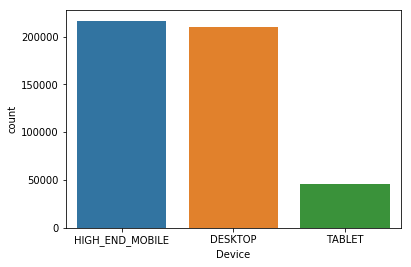

In [138]:
sns.countplot(x="Device", data=train)
pd.crosstab(train.Device, train.Clicks, normalize='index')

Ну тут примерно все одинаково

Средняя позиция вроде как очевидно должна кореллировать с количеством кликов, проверим

Clicks,0,1
AveragePosition,,
1.0,0.787459,0.212541
1.1,0.810670,0.189330
1.2,0.854409,0.145591
1.3,0.878857,0.121143
1.4,0.917642,0.082358
1.5,0.883038,0.116962
1.6,0.948627,0.051373
1.7,0.908412,0.091588
1.8,0.950460,0.049540


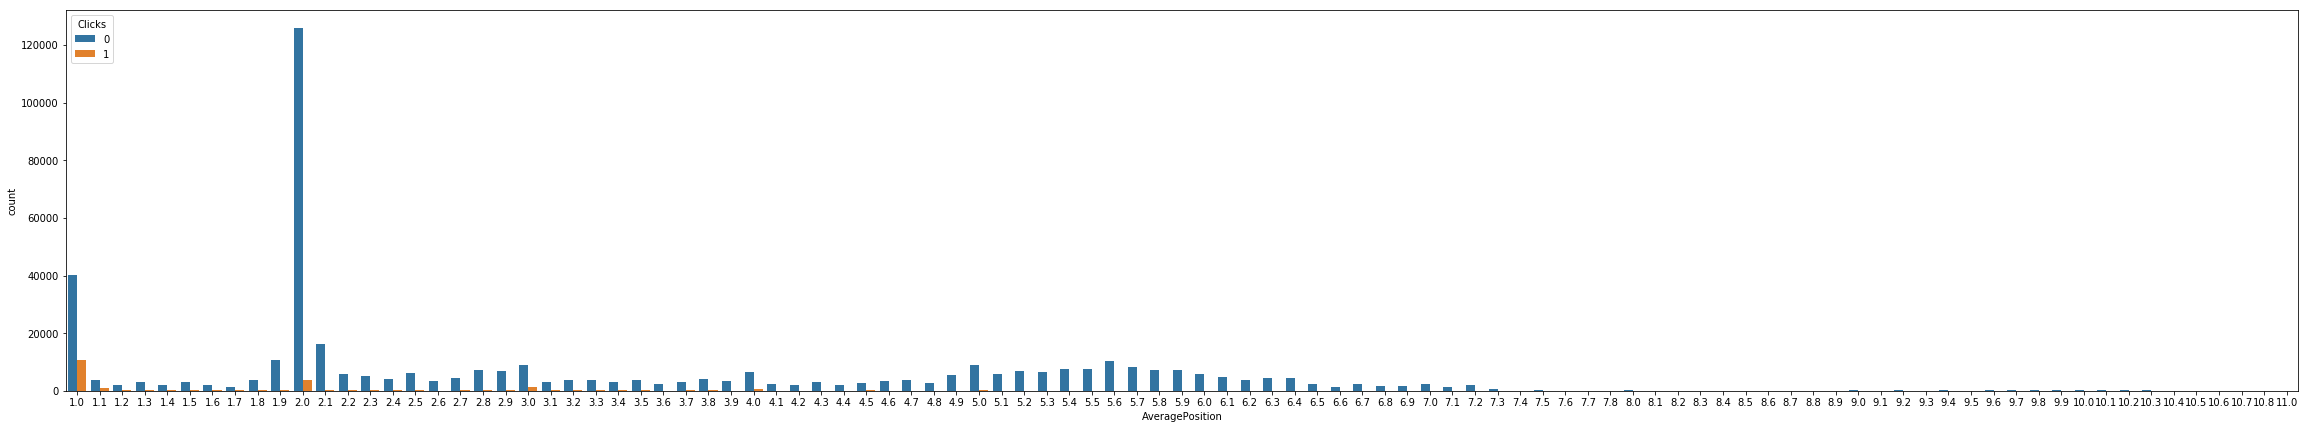

In [139]:
plt.figure(figsize=(40,7))
sns.countplot(x="AveragePosition", data=train, hue='Clicks')
pd.crosstab(train.AveragePosition, train.Clicks, normalize='index')

По сути так и есть. Разберемся со временем

In [140]:
print(train.Date.describe(), '\n', test.Date.describe())

count                  472023
unique                    363
top       2016-06-27 00:00:00
freq                     4826
first     2016-01-01 00:00:00
last      2016-12-31 00:00:00
Name: Date, dtype: object 
 count                   87807
unique                     50
top       2017-02-01 00:00:00
freq                     2869
first     2017-01-01 00:00:00
last      2017-02-19 00:00:00
Name: Date, dtype: object


Интересно посмотреть, как зависит CTR от дня недели

In [141]:
train['Day_of_week'] = train['Date'].apply(lambda day: day.weekday_name)
test['Day_of_week'] = test['Date'].apply(lambda day: day.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

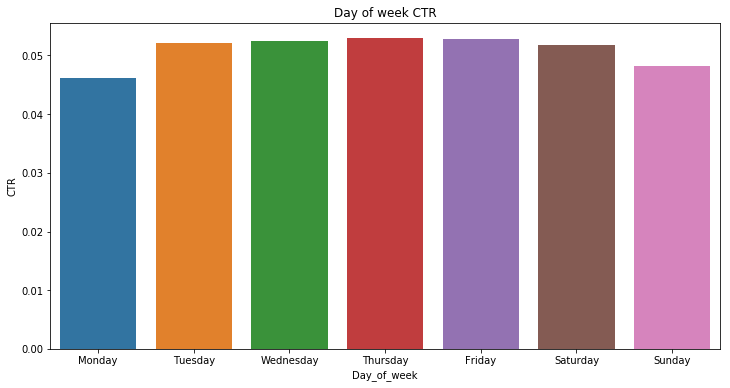

In [142]:
df_click = train[train['Clicks'] == 1]
df_dayofweek = train[['Day_of_week','Clicks']].groupby(['Day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'Clicks': 'impressions'})
df_dayofweek['Clicks'] = df_click[['Day_of_week','Clicks']].groupby(['Day_of_week']).count().reset_index()['Clicks']
df_dayofweek['CTR'] = df_dayofweek['Clicks']/df_dayofweek['impressions']
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='Day_of_week', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR');

Прямо скажем не сильно отличается, но как фичу можно оставить

In [143]:
train.drop(["Date"], axis=1, inplace=True)
test.drop(["Date", "Id"], axis=1, inplace=True)

Заэнкодим категориальные переменные (если быть честным, они тут все, кроме кликов и показов, категориальные, но речь про
категориальные-текстовые)

In [144]:
y = train['Clicks']
train.drop(['Clicks'], axis=1, inplace=True)

Сделаем по-тупому - заэнкодим все запросы. После этого оценим важность фич и, оставив самые необходимые, обучимся еще раз

In [145]:
train['train'] = 1
test['train'] = 0
combined = pd.concat([train, test])
combined= pd.get_dummies(combined, columns=["QueryMatchTypeWithVariant", 'AdGroupId',
                                      "Device", 'CampaignId', 'KeywordId', 'Query'])
train = combined[combined['train'] == 1]
test = combined[combined['train'] == 0]
train.drop(['train'], axis=1, inplace=True)
test.drop(['train'], axis=1, inplace=True)

/Users/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [146]:
scaler = MinMaxScaler()

#train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
#test = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)

test.head()

,AveragePosition,Day_of_week,QueryMatchTypeWithVariant_EXACT,QueryMatchTypeWithVariant_EXPANDED,QueryMatchTypeWithVariant_NEAR_EXACT,QueryMatchTypeWithVariant_NEAR_PHRASE,QueryMatchTypeWithVariant_PHRASE,AdGroupId_7953835370,AdGroupId_7953835490,AdGroupId_7953835610,...,Query_är det värt att ta billån,Query_är freedom finance omdöme,Query_är handpenning bindande vid bilköp,Query_är lendo bra,Query_är marginalen bank bra,Query_är santander bra,Query_är santander lån bra,Query_återbetalningstid billån,Query_رقم تلفون wasa kredit ab في السويد,Query_ًً lendo
0,1.7,Friday,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,Thursday,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,Tuesday,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.9,Thursday,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,Sunday,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [147]:
train.head()

,AveragePosition,Day_of_week,QueryMatchTypeWithVariant_EXACT,QueryMatchTypeWithVariant_EXPANDED,QueryMatchTypeWithVariant_NEAR_EXACT,QueryMatchTypeWithVariant_NEAR_PHRASE,QueryMatchTypeWithVariant_PHRASE,AdGroupId_7953835370,AdGroupId_7953835490,AdGroupId_7953835610,...,Query_är det värt att ta billån,Query_är freedom finance omdöme,Query_är handpenning bindande vid bilköp,Query_är lendo bra,Query_är marginalen bank bra,Query_är santander bra,Query_är santander lån bra,Query_återbetalningstid billån,Query_رقم تلفون wasa kredit ab في السويد,Query_ًً lendo
0,1.0,Friday,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,Friday,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,Tuesday,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,Tuesday,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,Monday,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [148]:
def save_prediction(prediction, file_name):
    pd.DataFrame({"Id":list(range(0, 87807)),"ClickProbability":prediction}).to_csv(file_name,
                                                                                          index=False,header=True)

In [66]:
train_split, test_split, y_train_split, y_test_split = train_test_split(train, y, 
                                                                        test_size=0.1, random_state=42)

In [67]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train_split, y_train_split)
lgb_eval = lgb.Dataset(test_split, y_test_split, reference=lgb_train)

In [68]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.3,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                early_stopping_rounds=500)

Start training...
[1]	valid_0's binary_logloss: 0.182573
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's binary_logloss: 0.173535
[3]	valid_0's binary_logloss: 0.167305
[4]	valid_0's binary_logloss: 0.162539
[5]	valid_0's binary_logloss: 0.158778
[6]	valid_0's binary_logloss: 0.155617
[7]	valid_0's binary_logloss: 0.15309
[8]	valid_0's binary_logloss: 0.150869
[9]	valid_0's binary_logloss: 0.148967
[10]	valid_0's binary_logloss: 0.147337
[11]	valid_0's binary_logloss: 0.145872
[12]	valid_0's binary_logloss: 0.144605
[13]	valid_0's binary_logloss: 0.143467
[14]	valid_0's binary_logloss: 0.142569
[15]	valid_0's binary_logloss: 0.141747
[16]	valid_0's binary_logloss: 0.141027
[17]	valid_0's binary_logloss: 0.1404
[18]	valid_0's binary_logloss: 0.139846
[19]	valid_0's binary_logloss: 0.139348
[20]	valid_0's binary_logloss: 0.138933
[21]	valid_0's binary_logloss: 0.138523
[22]	valid_0's binary_logloss: 0.138139
[23]	valid_0's binary_logloss: 0.137817
[24]	valid_

[204]	valid_0's binary_logloss: 0.132296
[205]	valid_0's binary_logloss: 0.132277
[206]	valid_0's binary_logloss: 0.132283
[207]	valid_0's binary_logloss: 0.132289
[208]	valid_0's binary_logloss: 0.132296
[209]	valid_0's binary_logloss: 0.132308
[210]	valid_0's binary_logloss: 0.132324
[211]	valid_0's binary_logloss: 0.132317
[212]	valid_0's binary_logloss: 0.132305
[213]	valid_0's binary_logloss: 0.132276
[214]	valid_0's binary_logloss: 0.132285
[215]	valid_0's binary_logloss: 0.132284
[216]	valid_0's binary_logloss: 0.132266
[217]	valid_0's binary_logloss: 0.132255
[218]	valid_0's binary_logloss: 0.132252
[219]	valid_0's binary_logloss: 0.132252
[220]	valid_0's binary_logloss: 0.132246
[221]	valid_0's binary_logloss: 0.132229
[222]	valid_0's binary_logloss: 0.132209
[223]	valid_0's binary_logloss: 0.132193
[224]	valid_0's binary_logloss: 0.132188
[225]	valid_0's binary_logloss: 0.13218
[226]	valid_0's binary_logloss: 0.132169
[227]	valid_0's binary_logloss: 0.132161
[228]	valid_0's b

[406]	valid_0's binary_logloss: 0.13197
[407]	valid_0's binary_logloss: 0.131965
[408]	valid_0's binary_logloss: 0.131956
[409]	valid_0's binary_logloss: 0.131949
[410]	valid_0's binary_logloss: 0.131945
[411]	valid_0's binary_logloss: 0.131954
[412]	valid_0's binary_logloss: 0.131963
[413]	valid_0's binary_logloss: 0.131956
[414]	valid_0's binary_logloss: 0.131964
[415]	valid_0's binary_logloss: 0.13198
[416]	valid_0's binary_logloss: 0.131994
[417]	valid_0's binary_logloss: 0.132022
[418]	valid_0's binary_logloss: 0.132026
[419]	valid_0's binary_logloss: 0.132045
[420]	valid_0's binary_logloss: 0.132068
[421]	valid_0's binary_logloss: 0.132072
[422]	valid_0's binary_logloss: 0.132069
[423]	valid_0's binary_logloss: 0.132067
[424]	valid_0's binary_logloss: 0.132061
[425]	valid_0's binary_logloss: 0.132067
[426]	valid_0's binary_logloss: 0.132053
[427]	valid_0's binary_logloss: 0.132054
[428]	valid_0's binary_logloss: 0.132069
[429]	valid_0's binary_logloss: 0.132072
[430]	valid_0's bi

[609]	valid_0's binary_logloss: 0.131979
[610]	valid_0's binary_logloss: 0.131998
[611]	valid_0's binary_logloss: 0.132
[612]	valid_0's binary_logloss: 0.132013
[613]	valid_0's binary_logloss: 0.132027
[614]	valid_0's binary_logloss: 0.132033
[615]	valid_0's binary_logloss: 0.132037
[616]	valid_0's binary_logloss: 0.132035
[617]	valid_0's binary_logloss: 0.132031
[618]	valid_0's binary_logloss: 0.132023
[619]	valid_0's binary_logloss: 0.132024
[620]	valid_0's binary_logloss: 0.132033
[621]	valid_0's binary_logloss: 0.132036
[622]	valid_0's binary_logloss: 0.132046
[623]	valid_0's binary_logloss: 0.132047
[624]	valid_0's binary_logloss: 0.132049
[625]	valid_0's binary_logloss: 0.132062
[626]	valid_0's binary_logloss: 0.132062
[627]	valid_0's binary_logloss: 0.132049
[628]	valid_0's binary_logloss: 0.132052
[629]	valid_0's binary_logloss: 0.13205
[630]	valid_0's binary_logloss: 0.132045
[631]	valid_0's binary_logloss: 0.132017
[632]	valid_0's binary_logloss: 0.132005
[633]	valid_0's bina

[810]	valid_0's binary_logloss: 0.132229
[811]	valid_0's binary_logloss: 0.132225
[812]	valid_0's binary_logloss: 0.132208
[813]	valid_0's binary_logloss: 0.132218
[814]	valid_0's binary_logloss: 0.13221
[815]	valid_0's binary_logloss: 0.1322
[816]	valid_0's binary_logloss: 0.132197
[817]	valid_0's binary_logloss: 0.132189
[818]	valid_0's binary_logloss: 0.132178
[819]	valid_0's binary_logloss: 0.132169
[820]	valid_0's binary_logloss: 0.132163
[821]	valid_0's binary_logloss: 0.132156
[822]	valid_0's binary_logloss: 0.132171
[823]	valid_0's binary_logloss: 0.132183
[824]	valid_0's binary_logloss: 0.132189
[825]	valid_0's binary_logloss: 0.132182
[826]	valid_0's binary_logloss: 0.1322
[827]	valid_0's binary_logloss: 0.132206
[828]	valid_0's binary_logloss: 0.132218
[829]	valid_0's binary_logloss: 0.132243
[830]	valid_0's binary_logloss: 0.132259
[831]	valid_0's binary_logloss: 0.132252
[832]	valid_0's binary_logloss: 0.132247
[833]	valid_0's binary_logloss: 0.132255
[834]	valid_0's binar

In [112]:
print(gbm.best_score)
print(gbm.best_iteration)

defaultdict(<class 'dict'>, {'valid_0': {'binary_logloss': 0.13194507788737744}})
410


In [113]:
labels= gbm.predict(test)

In [114]:
print(labels)

[0.03229603 0.09780302 0.00562612 ... 0.08744179 0.0662839  0.00562612]


In [115]:
save_prediction(labels, 'lgbm.csv')

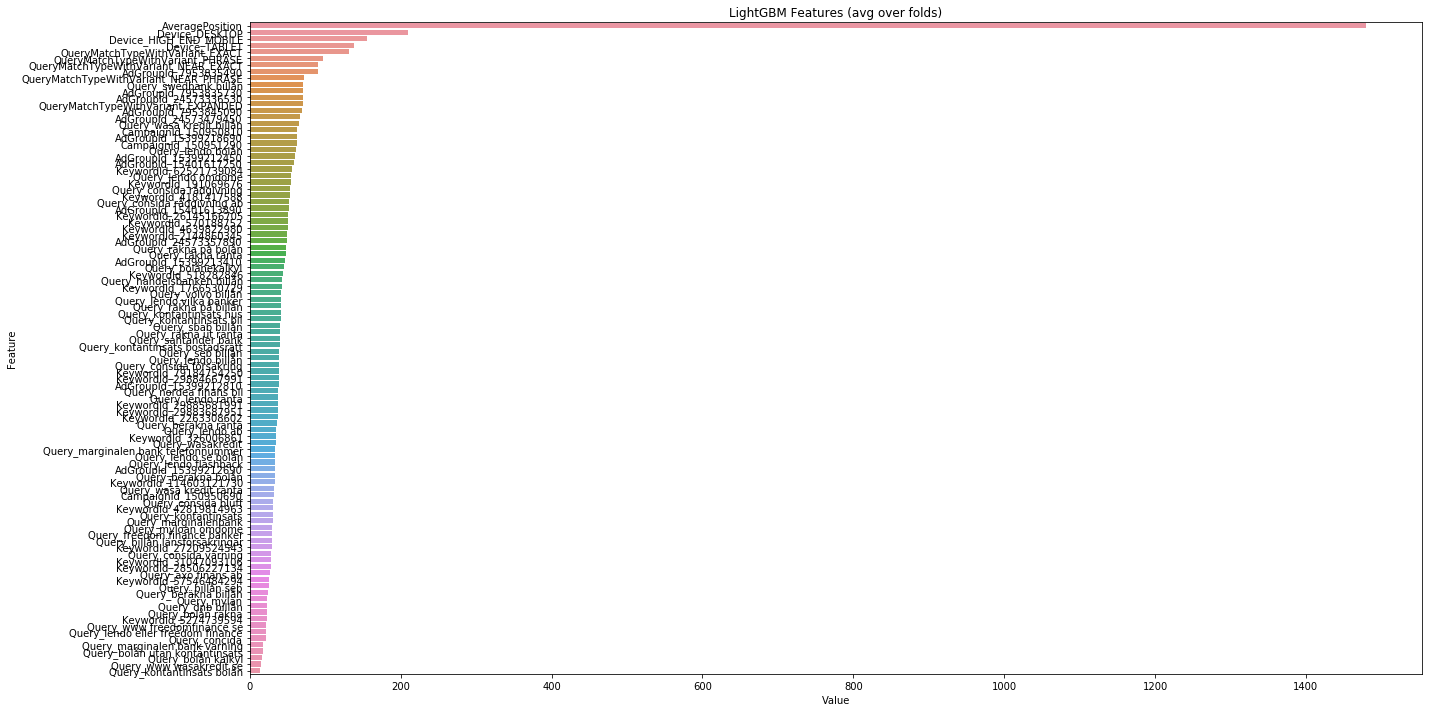

In [149]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), train_split.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:100])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [150]:
feature_imp = list(feature_imp.sort_values(by="Value", ascending=False)[0:300]['Feature'])

In [151]:
train = train[feature_imp]
test = test[feature_imp]

In [152]:
train_split, test_split, y_train_split, y_test_split = train_test_split(train, y, 
                                                                        test_size=0.1, random_state=42)

In [153]:
lgb_train = lgb.Dataset(train_split, y_train_split)
lgb_eval = lgb.Dataset(test_split, y_test_split, reference=lgb_train)

In [154]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.3,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                early_stopping_rounds=500)

Start training...
[1]	valid_0's binary_logloss: 0.186095
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's binary_logloss: 0.176789
[3]	valid_0's binary_logloss: 0.169894
[4]	valid_0's binary_logloss: 0.164262
[5]	valid_0's binary_logloss: 0.160156
[6]	valid_0's binary_logloss: 0.156569
[7]	valid_0's binary_logloss: 0.153792
[8]	valid_0's binary_logloss: 0.151478
[9]	valid_0's binary_logloss: 0.149535
[10]	valid_0's binary_logloss: 0.147914
[11]	valid_0's binary_logloss: 0.146421
[12]	valid_0's binary_logloss: 0.145137
[13]	valid_0's binary_logloss: 0.143891
[14]	valid_0's binary_logloss: 0.142957
[15]	valid_0's binary_logloss: 0.14205
[16]	valid_0's binary_logloss: 0.141271
[17]	valid_0's binary_logloss: 0.140554
[18]	valid_0's binary_logloss: 0.139909
[19]	valid_0's binary_logloss: 0.139444
[20]	valid_0's binary_logloss: 0.138973
[21]	valid_0's binary_logloss: 0.138488
[22]	valid_0's binary_logloss: 0.138109
[23]	valid_0's binary_logloss: 0.137775
[24]	vali

[206]	valid_0's binary_logloss: 0.133657
[207]	valid_0's binary_logloss: 0.133668
[208]	valid_0's binary_logloss: 0.133672
[209]	valid_0's binary_logloss: 0.133664
[210]	valid_0's binary_logloss: 0.133667
[211]	valid_0's binary_logloss: 0.133656
[212]	valid_0's binary_logloss: 0.133652
[213]	valid_0's binary_logloss: 0.133648
[214]	valid_0's binary_logloss: 0.133648
[215]	valid_0's binary_logloss: 0.13364
[216]	valid_0's binary_logloss: 0.133647
[217]	valid_0's binary_logloss: 0.133646
[218]	valid_0's binary_logloss: 0.133638
[219]	valid_0's binary_logloss: 0.133654
[220]	valid_0's binary_logloss: 0.133647
[221]	valid_0's binary_logloss: 0.133664
[222]	valid_0's binary_logloss: 0.133687
[223]	valid_0's binary_logloss: 0.133688
[224]	valid_0's binary_logloss: 0.133704
[225]	valid_0's binary_logloss: 0.133709
[226]	valid_0's binary_logloss: 0.133708
[227]	valid_0's binary_logloss: 0.133713
[228]	valid_0's binary_logloss: 0.133722
[229]	valid_0's binary_logloss: 0.133714
[230]	valid_0's b

[407]	valid_0's binary_logloss: 0.133769
[408]	valid_0's binary_logloss: 0.133765
[409]	valid_0's binary_logloss: 0.133773
[410]	valid_0's binary_logloss: 0.13377
[411]	valid_0's binary_logloss: 0.133774
[412]	valid_0's binary_logloss: 0.133771
[413]	valid_0's binary_logloss: 0.13377
[414]	valid_0's binary_logloss: 0.133776
[415]	valid_0's binary_logloss: 0.133778
[416]	valid_0's binary_logloss: 0.133781
[417]	valid_0's binary_logloss: 0.133788
[418]	valid_0's binary_logloss: 0.133786
[419]	valid_0's binary_logloss: 0.133799
[420]	valid_0's binary_logloss: 0.133807
[421]	valid_0's binary_logloss: 0.133811
[422]	valid_0's binary_logloss: 0.133799
[423]	valid_0's binary_logloss: 0.133796
[424]	valid_0's binary_logloss: 0.133792
[425]	valid_0's binary_logloss: 0.133787
[426]	valid_0's binary_logloss: 0.133799
[427]	valid_0's binary_logloss: 0.133818
[428]	valid_0's binary_logloss: 0.13383
[429]	valid_0's binary_logloss: 0.133845
[430]	valid_0's binary_logloss: 0.133856
[431]	valid_0's bin

[612]	valid_0's binary_logloss: 0.134119
[613]	valid_0's binary_logloss: 0.134099
[614]	valid_0's binary_logloss: 0.134087
[615]	valid_0's binary_logloss: 0.134083
[616]	valid_0's binary_logloss: 0.134079
[617]	valid_0's binary_logloss: 0.134068
[618]	valid_0's binary_logloss: 0.134081
[619]	valid_0's binary_logloss: 0.13408
[620]	valid_0's binary_logloss: 0.134075
[621]	valid_0's binary_logloss: 0.134063
[622]	valid_0's binary_logloss: 0.134054
[623]	valid_0's binary_logloss: 0.134052
[624]	valid_0's binary_logloss: 0.134047
[625]	valid_0's binary_logloss: 0.134055
[626]	valid_0's binary_logloss: 0.134055
[627]	valid_0's binary_logloss: 0.134064
[628]	valid_0's binary_logloss: 0.134071
[629]	valid_0's binary_logloss: 0.134073
[630]	valid_0's binary_logloss: 0.134081
[631]	valid_0's binary_logloss: 0.134092
[632]	valid_0's binary_logloss: 0.134073
[633]	valid_0's binary_logloss: 0.134072
[634]	valid_0's binary_logloss: 0.134066
[635]	valid_0's binary_logloss: 0.134067
[636]	valid_0's b

[814]	valid_0's binary_logloss: 0.134341
[815]	valid_0's binary_logloss: 0.134348
[816]	valid_0's binary_logloss: 0.134362
[817]	valid_0's binary_logloss: 0.134369
[818]	valid_0's binary_logloss: 0.134377
[819]	valid_0's binary_logloss: 0.134381
[820]	valid_0's binary_logloss: 0.134378
[821]	valid_0's binary_logloss: 0.134371
[822]	valid_0's binary_logloss: 0.134382
[823]	valid_0's binary_logloss: 0.134366
[824]	valid_0's binary_logloss: 0.134381
[825]	valid_0's binary_logloss: 0.13439
[826]	valid_0's binary_logloss: 0.134392
[827]	valid_0's binary_logloss: 0.13439
[828]	valid_0's binary_logloss: 0.1344
[829]	valid_0's binary_logloss: 0.134397
[830]	valid_0's binary_logloss: 0.134402
[831]	valid_0's binary_logloss: 0.134421
[832]	valid_0's binary_logloss: 0.134441
Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 0.13357


In [155]:
print(gbm.best_score)
print(gbm.best_iteration)

defaultdict(<class 'dict'>, {'valid_0': {'binary_logloss': 0.1335704677890498}})
332


In [156]:
labels= gbm.predict(test)

In [157]:
print(labels)

[0.02821653 0.10242369 0.00593685 ... 0.07290474 0.05581112 0.00593685]


In [158]:
save_prediction(labels, 'lgbm.csv')